In [1]:
from utils.utils import *

os.makedirs("1.Minimal_structures", exist_ok=True)

structures_path = "1.Minimal_structures/Minimal_structures"
os.makedirs(structures_path, exist_ok=True)

Cif.path = structures_path
Cif.original_cifs_path = "/home/fnerin/Desktop/allodb_new/src/data" # <pdb>_updated.cif.gz

# allodb

In [2]:
import sys
sys.path.append("..")

from src import *

db.init('../database.db')

# "Minimal" structure selection

- Only sites where the annotated modulator(s) is a small molecule (entity type "non-polymer"), and not all of the molecules are ions, are used.
- Only the chains in contact with the annotated modulator in the biological assembly (the one where the modulator is present), and that contribute with more than 3 residues to the site, are selected. If the assembly is a repetition of the asymmetric unit/model, the model is used.
- The equivalent related sites (sites formed by the same modulator molecule involving the same residues than the principal site on a different chain of the same protein), stored in the Site .info attribute, are also annotated in the remaining structure, if their sites are present in it and are more than 3 residues.
- The following conclusions established in `Statistics.ipynb` apply:

    - All protein chains of **length <= 24** will not be taken into account (but other chains of the sites that do not meet this criteria will remain, if there were)
        - Short chains of length <=21 not associated to a Uniprot and that are from a site in which another bigger, Uniprot-associated chain is also forming the site will not be taken into account
        - Short chains of length <=24 even if they are associated to a Uniprot and are the only ones forming an allosteric site, i.e. 5c6d, 4riq; also because the annotated modulator is bigger than the chain and might introduce noise
    - Chains of **length <=31 associated to a Uniprot and from a site in which another** bigger, different-Uniprot-associated chain is also forming the site (if they have the same Uniprot as the bigger chain, they will be kept)

## Structure selection and saving

In [ ]:
from utils.structure_fixing import get_fixed_structure

In [3]:
def has_other_uniprots(s, asym_id):
    """
    Check if there are any other protein chains in the site ('s') different than the 'asym_id' that are associated with a Uniprot and length >31 (Statistics.ipynb rules).
    """
    return any(
        # is associated to a Uniprot
        (
            "pdbx_sifts_xref_db_acc" in other_asym_res.columns
            and len(
                set(other_asym_res.pdbx_sifts_xref_db_acc.unique().tolist()) - set(("?",))
            ) >= 1 
        )
        # and length >31
        and len(other_asym_res) > 31

        # For each protein chain in the site
        for other_asym_id in s.protein_residues.label_asym_id.unique()
        # If it's not asym_id
        if other_asym_id != asym_id
            # all residues of the other_chain
            for other_asym_res in (s.pdb.residues.query(f"label_asym_id == '{other_asym_id}' and pdbx_PDB_model_num == '1'"),) 
    )


def get_chains(pdb, p, sites):
    """
    Return a list of the label_asym_id of the protein chains that participate in the site and meet the criteria defined above.
    """
    return tuple(
        asym_id
        for s in sites
            # for each protein chain of the site
            for asym_id, asym_res in s.protein_residues.query(f"pdbx_PDB_model_num == '1'").groupby("label_asym_id")
                # if it is on the structure to be used and provides enough residues to the site
                    if asym_id in p.residues.label_asym_id.unique() and len(asym_res) > 3
                        # (and get the whole protein chain based on the structure the site is coming from (could be assembly))
                        for chain_res in (s.pdb.residues.query(f"label_asym_id == '{asym_id}' and pdbx_PDB_model_num == '1'"),)
                            # and only if the chain passes the Statistics.ipynb rules above
                            if not (
                                # the chain length is 31 or less
                                len(chain_res) <= 31
                                and (
                                    # AND it is simply 24 or less
                                    len(chain_res) <= 24 
                                    # OR there are other chains in the site BOTH associated to a Uniprot AND with length of more than 31
                                    or has_other_uniprots(s, asym_id)
                                )
                            )
    )



import datetime

def get_sites(pdb, p, minimal_chains):
    """
    Retrieve a dict of all sites of a 'pdb', including the modulator and the site residues (that can be found in the minimal structure 'p' and part of chains 'minimal_chains'), if the site is larger than 3 residues. 
    Also retrieve the mod and residues of each site's equivalent sites, (that can be found in p and part of minimal_chains).
    """
    # Run inside a transaction to create temporary/"fake" sites for the equivalent sites and retrieve their info, and delete them in the end
    with db.transaction() as txn:
        sites = {}
        # For each site in the pdb
        for s in list(pdb.sites):
            # Skip site if it isn't a small-molecule or it's all ions
            if any(
                mod["type"] != "non-polymer"
                for mod in s.info["modulator_info"]
            ) or all(
                mod["type"] == "non-polymer" \
                and mod["pdbx_description"].lower().endswith(" ion")
                for mod in s.info["modulator_info"]
            ): 
                continue
            # Retrieve its residues in the p structure and minimal_chains, and save it if satisfactory and >3 residues
            res = s.protein_residues.query(f"label_asym_id in {minimal_chains} and pdbx_PDB_model_num == '1'").merge(p.residues)
            if len(res) > 3:
                sites[s.id] = {
                    "mod": s.modulator_residues.query("pdbx_PDB_model_num == '1'"),
                    "site": res,
                    "equivalent": []
                }

            # For each equivalent site of the site
            for other in s.related_sites["equivalent"]:
                # Create a fake site
                os = Site.create(
                    pdb=pdb.entry_id, 
                    modulator=other["other_site"], 
                    updated=datetime.date.today()
                )
                # And retrieve its residues in the p structure and minimal_chains, and save it if satisfactory and >3 residues
                res = (
                    os.protein_residues.query(f"label_asym_id in {minimal_chains} and pdbx_PDB_model_num == '1'")
                    .merge(p.residues)
                )
                if len(res) > 3:
                    sites[s.id]["equivalent"].append({
                        "mod": os.modulator_residues.query("pdbx_PDB_model_num == '1'"),
                        "site": res
                    })
        # Rollback changes in the transaction            
        txn.rollback()
    return sites



def get_assembly_structure(pdb):
    """
    Return the structure of a biological assembly if available and if it meets the criteria
    """
    p = pdb
    if pdb.entry_id != '5n70': # PDB with the protein chain and mod. in different assemblies
        # Make a list of the assembly ids where the modulators of each of the sites are present (ideally, the first, but might not be)
        assembly_ids = sorted(set(
            s._pdb._name.split("_assembly")[-1] 
                for site in pdb.sites
                    for s in [site.assembly_site or site,]
                        if type(s._pdb) != PDB
        ))
        # Check if there's more than 1 possible assembly id to choose from, and then simply choose first (or the only one)
        if len(assembly_ids) > 1:
            print("MODS IN DIFF ASSEMBLIES", pdb.entry_id) # but select one anyway
        if len(assembly_ids) > 0:
            p = pdb.assembly(assembly_ids[0]).minimal_pdb
    return p



def get_structure_sites(pdb, path, save=True):
    """
    Get the minimal structure of the pdb according to the criteria above, and save a fixed minimal structure and return a dictionary with the sites' information in such minimal structure
    """
    p = pdb.minimal_pdb
    sites = list(pdb.sites)

    # Switch to the assembly if criteria is met
    if pdb.assembly is not None and pdb.entry_id != '5n70':
        if pdb.assembly._repetitions is None:
            p = get_assembly_structure(pdb)
            sites = [s.assembly_site for s in sites]
        else:
            print(pdb.entry_id, "has a repetition-assembly so the model will be used")

    # Get the minimal chains of the pdb
    minimal_chains = get_chains(pdb, p, sites)

    # If the chain selection was successful (e.g., it's a protein structure)
    if len(minimal_chains):
        # Get a dictionary of the site
        sitesd = get_sites(pdb, p, minimal_chains)
        # If there are indeed sites
        if len(sitesd):
            # Save the fixed structure and return the site information
            fixed_structure = get_fixed_structure(pdb, p, minimal_chains, path=path, save=save)
            return (pdb.entry_id, sitesd)
        else:
            print(pdb, "doesn't have sites satisfying conditions")
    else:
        print(pdb, "doesn't have a valid minimal structure")

## Run

In [17]:
sitesf = "1.Minimal_structures/sites.pkl"

if not os.path.isfile(sitesf):
    sites = tuple(get_structure_sites(pdb, structures_path, save=True) for pdb in tqdm(PDB.select(), smoothing=0))
    sites = dict(p for p in sites if p is not None)
    with open(sitesf, "wb") as f:
        pickle.dump(sites, f)
else:
    with open(sitesf, "rb") as f:
        sites = pickle.load(f)

  0%|          | 0/3078 [00:00<?, ?it/s]

5lvp doesn't have sites satisfying conditions
6i53 doesn't have sites satisfying conditions
4o3t doesn't have sites satisfying conditions
4o3u doesn't have sites satisfying conditions
1l5g doesn't have sites satisfying conditions
3wmg doesn't have sites satisfying conditions
4fgt has a repetition-assembly so the model will be used
4fgt doesn't have sites satisfying conditions
4c3p doesn't have sites satisfying conditions
5g15 doesn't have sites satisfying conditions
5l8j doesn't have sites satisfying conditions
5l8k doesn't have sites satisfying conditions
5l8l doesn't have sites satisfying conditions
5dc4 doesn't have sites satisfying conditions
1soz doesn't have sites satisfying conditions
2r3y doesn't have sites satisfying conditions
3gcn doesn't have sites satisfying conditions
3gco has a repetition-assembly so the model will be used
3gco doesn't have sites satisfying conditions
3gds has a repetition-assembly so the model will be used
3gds doesn't have sites satisfying conditions
3

In [5]:
db.close()

False

- 5c6d, 4riq, 5l32, 2hh7 are structures that do not meet the criteria above (e.g., annotated modulator is bigger than the chain).
- 5hcj, 5hcm, 5iwd have a small modulator that doesn't involve more than 3 residues in any of the chains of the site, and therefore a valid minimal_chains isn't retrieved.
- 3irw, 3iwn, 3mum, 3mur, 3mut, 3muv, 3mxh, 3owi, 3oww, 3owz, 3oxe, 3oxj, 3oxm, 3q3z are nucleic acid structures, mainly riboswitches, and 4v9c is the ribosome.

<br>

## Number of chains and residues

In [7]:
nres = pd.DataFrame({
    cif.entry_id: {
        "nres": len(cif.residues),
        "nchains": len(cif.residues.label_asym_id.unique())
    }
    for pdb in tqdm(sites, smoothing=0)
            for cif in (Cif(pdb),)
}).T

  0%|          | 0/2779 [00:00<?, ?it/s]

array([[<Axes: title={'center': 'nres'}>,
        <Axes: title={'center': 'nchains'}>]], dtype=object)

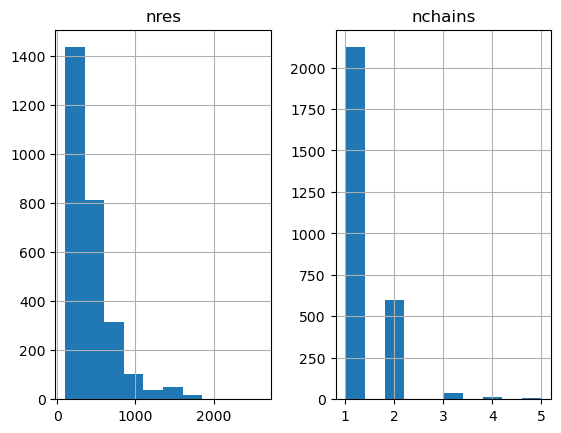

In [8]:
nres.hist()

In [11]:
# Number of structures with 3 chains or more (total: 2779)
nres["nchains"].loc[lambda x: x>2].sum()

196

<Axes: >

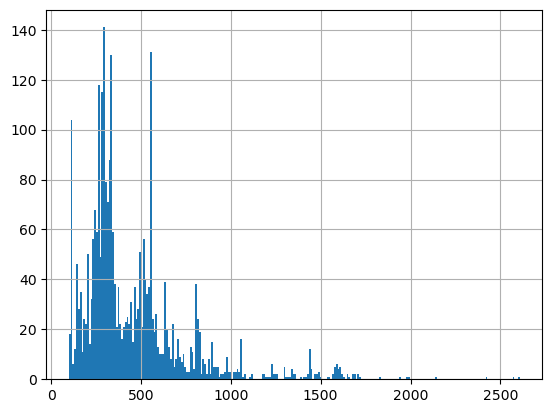

In [10]:
nres["nres"].hist(bins=250)